<h1><center>Подготовка прототипа модели машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды.</center></h1>

### Описание данных:

#### 1. Технологический процесс

 - Rougher feed — исходное сырье;
 - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant;
 - Xanthate — ксантогенат (промотер, или активатор флотации);
 - Sulphate — сульфат (на данном производстве сульфид натрия);
 - Depressant — депрессант (силикат натрия);
 - Rougher process (англ. «грубый процесс») — флотация;
 - Rougher tails — отвальные хвосты;
 - Float banks — флотационная установка;
 - Cleaner process — очистка;
 - Rougher Au — черновой концентрат золота;
 - Final Au — финальный концентрат золота.

#### 2. Параметры этапов

 - air amount — объём воздуха;
 - fluid levels — уровень жидкости;
 - feed size — размер гранул сырья;
 - feed rate — скорость подачи.

# 1. Предобработка данных

Загрузим все необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
pd.set_option('display.max_columns', None) 

Прочитаем файл datasets/gold_recovery_train.csv c обучающей выборкой и сохраним его в переменной gold_recovery_train. Получим первые 5 строк таблицы:

In [3]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Получим общую информацию о данных:

In [4]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

Столбцы "rougher.output.recovery" и "final.output.recovery" содержат целевые признаки, поэтому заполнение пропусков их средним, медианой или соседними значениями могут негативно повлиять на предсказания модели в дальнейшем, поэтому строки с пропусками в этих столбцах удалим:

In [5]:
gold_recovery_train = gold_recovery_train.dropna(axis='index', how='any', subset=['rougher.output.recovery'])

In [6]:
gold_recovery_train = gold_recovery_train.dropna(axis='index', how='any', subset=['final.output.recovery'])

Так как данные индексируются датой и временем получения информации и соседние по времени параметры часто похожи, заменим оставшиеся пропуски соседними значениями:

In [7]:
gold_recovery_train = gold_recovery_train.fillna(method='ffill')

Получим общую информацию по итоговой таблице:

In [8]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant             

Проверим, правильно ли рассчитана эффективность обогащения "rougher.output.recovery".

Сохраним в переменной C долю золота в концентрате после флотации:

In [9]:
C = gold_recovery_train['rougher.output.concentrate_au']

Сохраним в переменной F долю золота в сырье до флотации:

In [10]:
F = gold_recovery_train['rougher.input.feed_au']

Сохраним в переменной T долю золота в отвальных хвостах после флотации:

In [11]:
T = gold_recovery_train['rougher.output.tail_au']

Рассчитаем эффективность по формуле и сохраним значения в столбце "rougher.output.recovery2":

In [12]:
gold_recovery_train['rougher.output.recovery2'] = ((C*(F-T)) / (F*(C-T)))*100

Найдем MAE между нашими расчётами и значением признака:

In [13]:
mean_absolute_error(gold_recovery_train['rougher.output.recovery'], gold_recovery_train['rougher.output.recovery2'])

9.46896498277233e-15

### Вывод:

Предобработка обучающей выборки выполнена: пропуски в целевых признаках удалены, в остальных заменены на ближайшие значения. Целевой признак "rougher.output.recovery" рассчитан и проверен. Средняя сумма абсолютной разницы между исходным значением признака и рассчитанным нами крайне мала и связана, скорее всего, с погрешностью при округлении.

Прочитаем файл datasets/gold_recovery_test.csv c тестовой выборкой и сохраним его в переменной gold_recovery_test. Получим первые 5 строк таблицы:

In [14]:
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

Получим общую информацию:

In [15]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

Как и в случае с обучающей выборкой заменим пропущенные значения на ближайшие методом "ffill": 

In [16]:
gold_recovery_test = gold_recovery_test.fillna(method='ffill')

В тестовой выборке на 34 меньше столбцов, чем в обучающей. Выведим полный список из таких столбцов:

In [17]:
columns_list_train = list(gold_recovery_train)
columns_list_test = list(gold_recovery_test)

In [18]:
for i in columns_list_train:
    if i not in columns_list_test:
        print(i)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

### Вывод:

Из списка видно, что в тестовой выборке присутствуют только параметры исходного сырья и параметры, характеризующие состояние этапа. Расчетных характеристик и параметров продукта, таких как концентрация веществ здесь нет. Также отстутсвуют и целевые признаки - расчёт эффективность обогащения чернового и финального концентрата.

Прочитаем файл datasets/gold_recovery_full.csv c исходными данными и сохраним его в переменной gold_recovery_full. Получим первые 5 строк таблицы:

In [19]:
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')
gold_recovery_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Получим общую информацию по данным:

In [20]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Преобразуем столбец с датой в тестовой выборке и исходных данных в индекс:

In [21]:
gold_recovery_test.set_index('date',inplace=True)
gold_recovery_full.set_index('date',inplace=True)

Присоединим столбцы с целевыми признаками из исходных данных к тестовой выборке по соответствующим дате и времени:

In [22]:
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full[['final.output.recovery', 'rougher.output.recovery']], how='left', on='date')

Удалим строки с пропусками в целевых признаках:

In [23]:
gold_recovery_test = gold_recovery_test.dropna(axis='index', how='any', subset=['rougher.output.recovery'])

In [24]:
gold_recovery_test = gold_recovery_test.dropna(axis='index', how='any', subset=['final.output.recovery'])

Получим общую информацию по итоговой таблице с тестовой выборкой:

In [25]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.input.feed_ag                         529

Также удалим пропуски в целевых признаках и заменим на ближайшие значения в остальных для таблицы с исходными данными:

In [26]:
gold_recovery_full = gold_recovery_full.dropna(axis='index', how='any', subset=['rougher.output.recovery'])

In [27]:
gold_recovery_full = gold_recovery_full.dropna(axis='index', how='any', subset=['final.output.recovery'])

In [28]:
gold_recovery_full = gold_recovery_full.fillna(method='ffill')

### Вывод:

Предобработка тестовой выборки и исходных данных выполнена: пропуски в целевых признаках удалены, в остальных заменены на ближайшие значения. Также в тестовую выборку были добавлены столбцы с целевыми признаками для дальнейшей проверки эффективности обученной модели.

# 2. Исследовательский анализ данных

### 2.1 Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки:

Напишем функцию для построения графиков:

In [29]:
def painting (col, name, a, b):
    
    concentrate = gold_recovery_full.columns[gold_recovery_full.columns.str.contains(col)]
    
    plt.figure(figsize=(15,5))
    sns.boxplot(data=gold_recovery_full[concentrate[[2,1,0]]])
    sns.set_style("whitegrid")
    plt.title(name, fontsize=15)
    plt.ylim(a, b)
    plt.ylabel('Концентрация', fontsize=13)
    plt.xticks(np.arange(3), ('После флотации','После очистки','Финальный концентрат'), fontsize=13)
    plt.show()

#### 2.1.1 Изменения концентрации золота

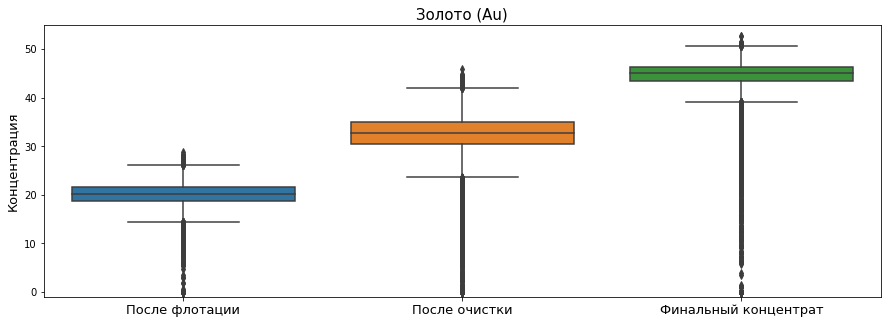

In [30]:
painting('concentrate_au', 'Золото (Au)', -1, 55)

#### 2.1.2 Изменения концентрации серебра

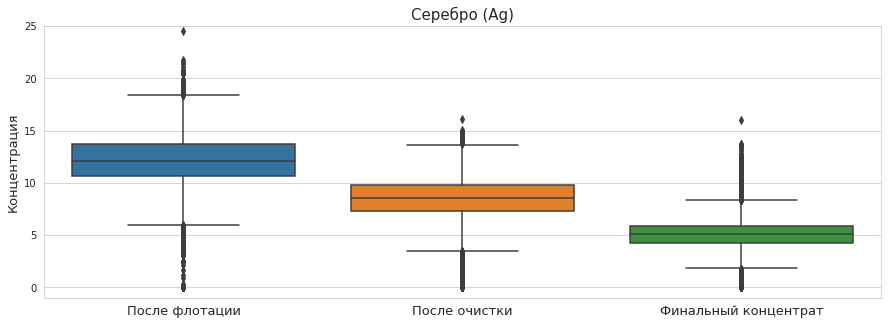

In [31]:
painting('concentrate_ag', 'Серебро (Ag)', -1, 25)

#### 2.1.3 Изменения концентрации свинца

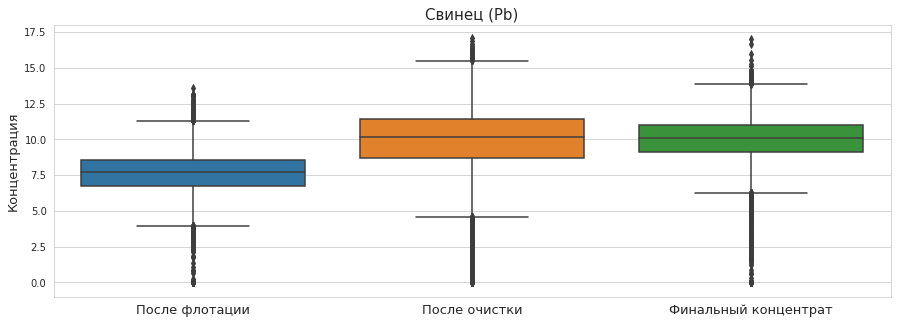

In [32]:
painting('concentrate_pb', 'Свинец (Pb)', -1, 18)

### Вывод:

В результате технологического процесса концентрация золота значительно увеличивается, приблизительно в 1.5 - 2 раза. По остальным металлам, изменения не столь значительны: увеличивается концентрация свинца, в то время как концентрация серебра снижается.

### 2.2 Сравним распределения размеров гранул сырья на обучающей и тестовой выборках:

Построим ящики с усами для распределения размеров гранул сырья по обучающей выборке:

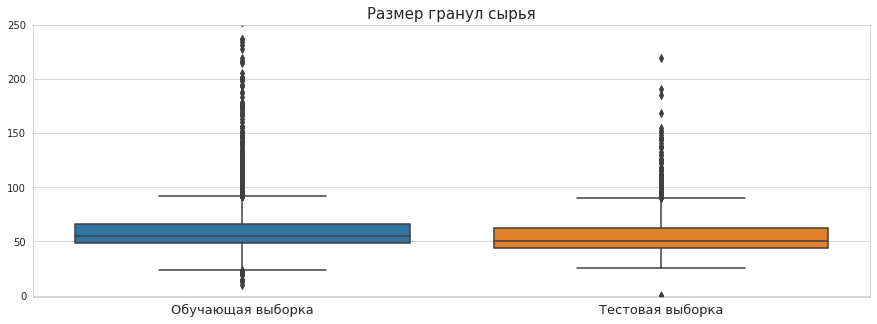

In [33]:
plt.figure(figsize=(15,5))
sns.boxplot(data=(gold_recovery_train['rougher.input.feed_size'], gold_recovery_test['rougher.input.feed_size']))
plt.title('Размер гранул сырья', fontsize=15)
plt.ylim(-1, 250)
plt.xticks(np.arange(2), ('Обучающая выборка','Тестовая выборка'), fontsize=13)
plt.show()

Получим описание данных для обучающей выборки:

In [34]:
gold_recovery_train['rougher.input.feed_size'].describe()

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Получим описание данных для тестовой выборки:

In [35]:
gold_recovery_test['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

### Вывод:

В ходе анализа мы убедились, что распределения размеров гранул сырья на обучающей и тестовой выборках отличаются друг от друга незначительно. В противном случае, оценка модели будет неправильной.

### 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Посчитаем суммарную концентрацию всех веществ в сырье:

In [36]:
gold_recovery_train['input_concentrate']=gold_recovery_train.iloc[:,34:36].sum(axis=1) + gold_recovery_train.iloc[:,38:40].sum(axis=1)

Посчитаем суммарную концентрацию всех веществ в черновом концентрате:

In [37]:
gold_recovery_train['output_concentrate']=gold_recovery_train.iloc[:,44:48].sum(axis=1)

Посчитаем суммарную концентрацию всех веществ в черновом концентрате после очистки:

In [38]:
gold_recovery_train['cleaner_concentrate']=gold_recovery_train.iloc[:,14:18].sum(axis=1)

Посчитаем суммарную концентрацию всех веществ в финальном концентрате:

In [39]:
gold_recovery_train['final_concentrate']=gold_recovery_train.iloc[:,1:5].sum(axis=1)

Отберем столбцы с полученными данными:

In [40]:
concentrate_train = gold_recovery_train.iloc[:, 88:92]
concentrate_train.head()

,input_concentrate,output_concentrate,cleaner_concentrate,final_concentrate
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667


Построим ящики с усами по суммарной концентрации всех веществ на разных стадиях:

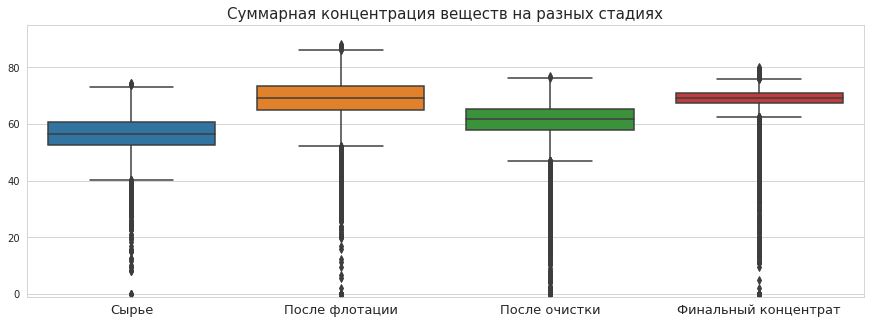

In [41]:
plt.figure(figsize=(15,5))
sns.boxplot(data=concentrate_train)
plt.title('Суммарная концентрация веществ на разных стадиях', fontsize=15)
plt.ylim(-1, 95)
plt.xticks(np.arange(4), ('Сырье','После флотации', 'После очистки', 'Финальный концентрат'), fontsize=13)
plt.show()

Получим описание данных:

In [42]:
concentrate_train.describe()

,input_concentrate,output_concentrate,cleaner_concentrate,final_concentrate
count,14149.000000,14149.000000,14149.000000,14149.000000
mean,56.242170,67.173145,60.172546,68.387872
std,7.029808,12.713129,10.448165,7.023723
min,0.040000,0.000000,0.000000,0.000000
25%,52.573579,64.914390,58.046816,67.559819
50%,56.627635,69.175663,61.786946,69.141502
75%,60.763234,73.429261,65.355951,70.974661
max,74.458253,88.140119,76.918076,80.210644


Удалим аномальные значения в виде нулей:

In [43]:
gold_recovery_train = gold_recovery_train.query('input_concentrate > 0.1')
gold_recovery_train = gold_recovery_train.query('output_concentrate > 0.1')
gold_recovery_train = gold_recovery_train.query('cleaner_concentrate > 0.1')
gold_recovery_train = gold_recovery_train.query('final_concentrate > 0.1')

Получим описание итоговых данных:

In [44]:
gold_recovery_train.iloc[:, 88:92].describe()

,input_concentrate,output_concentrate,cleaner_concentrate,final_concentrate
count,13602.000000,13602.000000,13602.000000,13602.000000
mean,56.251540,68.693370,60.948040,68.709318
std,6.877922,7.941778,7.694924,5.271479
min,8.217984,2.016647,0.113023,1.976540
25%,52.554878,65.313431,58.272697,67.560709
50%,56.619064,69.335791,61.837211,69.143403
75%,60.758700,73.530303,65.360175,70.965098
max,74.458253,88.140119,76.918076,80.210644


### Вывод:

В результате удаления аномальных значений в суммарном распределении разброс данных стал меньше. По описанию данных видно, что стандартные отклонения по всем столбцам значительно уменьшились, а медианы и средние значения стали ближе друг к другу.

# 3. Обучение модели

Подготовим данные к обучению. В тестовой выборке признаков меньше, чем в обучающей, сделаем выборки симметричными за счет удаления столбцов, которых нет в тестовой.

In [45]:
gold_recovery_test = gold_recovery_test.reset_index()

Сохраним наименования всех столбцов тестовой выборки в списке "columns_list":

In [46]:
columns_list = gold_recovery_test.columns

Отберем из обучающей выборки только те столбцы, которые есть в тестовой:

In [47]:
gold_recovery_train = gold_recovery_train.loc[:, gold_recovery_train.columns.isin(columns_list)]
gold_recovery_train.columns

Index(['date', 'final.output.recovery', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.recovery',
       'rougher.state.floatbank10_

Подготовим тестовую выборку. Признаки сохраним в переменной features_test. Для целевых признаков создадим переменную target_test:

In [48]:
target_test = gold_recovery_test[['rougher.output.recovery', 'final.output.recovery']]
features_test = gold_recovery_test.drop(['date','rougher.output.recovery', 'final.output.recovery'] , axis=1)

Выделим признаки в обучающей выборке по тому же принципу:

In [49]:
target_train = gold_recovery_train[['rougher.output.recovery', 'final.output.recovery']]
features_train = gold_recovery_train.drop(['date','rougher.output.recovery', 'final.output.recovery'] , axis=1)

Напишем функцию для вычисления итоговой SMAPE («Cимметричное среднее абсолютное процентное отклонение»):

In [50]:
 def smape(target, predict):
    predict = pd.DataFrame(predict)
    target.reset_index(inplace=True)
    smape_rougher = 100/len(predict[0]) * np.sum(2 * np.abs(target['rougher.output.recovery'] - predict[0]) / (np.abs(predict[0]) + np.abs(target['rougher.output.recovery'])))
    smape_final = 100/len(predict[1]) * np.sum(2 * np.abs(target['final.output.recovery'] - predict[1]) / (np.abs(predict[1]) + np.abs(target['final.output.recovery'])))
    return 0.25*smape_rougher + 0.75*smape_final

Обернем нашу функцию оценки SMAPE с параметром - чем меньше значение, тем лучше для дальнейшего использования:

In [51]:
smape_scorer = make_scorer(smape, greater_is_better = False)

### 3.1 Модель линейной регрессии

Обучим модель линейной регрессии и оценим её качество посредством кросс-валидации:

In [52]:
score = cross_val_score(LinearRegression(), features_train, target_train, scoring=smape_scorer, cv=5)

print('Лучшее значение sMAPE:', score.mean())

Лучшее значение sMAPE: -10.079140755126792


### 3.2 Дерево решений

Обучим модель дерева решений с наилучшими параметрами посредством кросс-валидации:

In [53]:
model = DecisionTreeRegressor(random_state=42)

In [54]:
tree_params = {'max_depth': range(3, 16, 2),
               'min_samples_split': range(2, 4),
               'min_samples_leaf': range(1, 3)}

In [55]:
DTR = GridSearchCV(model, tree_params, scoring=smape_scorer, cv=5)
DTR.fit(features_train, target_train)
DTR.best_params_

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [56]:
print('Лучшее значение sMAPE:', DTR.best_score_)

Лучшее значение sMAPE: -9.283946137153702


### 3.3 Случайный лес

Также как и в случае с деревом решений обучим модель случайного леса с наилучшими параметрами посредством кросс-валидации:

In [57]:
model_2 = RandomForestRegressor(random_state=42, n_estimators=150)

In [58]:
tree_params = {'max_features': ['auto', 'log2', 'sqrt'],
               'max_depth': range(2,5),
               'min_samples_leaf': range(1,14,3)}

In [59]:
RFR = GridSearchCV(model_2, tree_params, scoring=smape_scorer, cv=5)
RFR.fit(features_train, target_train)
RFR.best_params_

{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 13}

In [60]:
print('Лучшее значение sMAPE:', RFR.best_score_)

Лучшее значение sMAPE: -8.31546423052138


# 4. Тестирование модели

Оценим качество модели случайного леса с наилучшими параметрами на тестовой выборке:

In [61]:
predicted_test_final = RFR.predict(features_test)

In [62]:
print("SMAPE:", smape(target_test, predicted_test_final))

SMAPE: 8.840575725754588


Проверим модель на адекватность путем сравнения с константной моделью, которая каждому объекту будет прогнозировать среднее значение целевого признака. Чтобы пройти проверку, наша модель должна показать меньшее SMAPE, чем константная.

In [63]:
predicted_test_const_1 = pd.Series(target_test['rougher.output.recovery'].mean(), index=target_test.index)
predicted_test_const_2 = pd.Series(target_test['final.output.recovery'].mean(), index=target_test.index)
predicted_test_const = pd.concat([predicted_test_const_1, predicted_test_const_2], axis=1)

print("SMAPE:", smape(target_test, predicted_test_const))

SMAPE: 9.223908398047978


# 5. Вывод:

В ходе выполнения задания были:
 - проведена предобработка данных: обработаны пропуски в данных путем удаления и замены на ближайшие значения, добавлены недостающие значения, проверена правильность расчета целевого признака; 
 - проведен анализ данных: рассмотрено изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки путем построения гистограмм, произведено сравнение распределения размеров гранул сырья на обучающей и тестовой выборках путем построения ящиков с усами и таким же образом исследована суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах, что позволило выявить и удалить аномальные значения;
 - рассчитана метрика SMAPE, характеризующая симметричное среднее абсолютное процентное отклонение;
 - рассмотрены три модели регрессии: линейная регрессия, дерево решений и случайный лес. Путем кросс-валидации были подобраны наилучшие параметры моделей дерева решений и случайного леса по метрике SMAPE. Наилучший результат на обучающей выборке показала модель случайного леса со средним отклонением равным 8.32%. Данная модель была принята за основную  и показала на тестовой выборке среднее отклонение 8.84%, что на 0.38% меньше, чем у константной.